In [1]:
import os
import json
import math
import sys
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import wandb

from accelerate import Accelerator
from transformers import get_scheduler

from audiocraft.modules.conditioners import JointEmbedCondition, SegmentWithAttributes, WavCondition, ConditioningAttributes
from config import Config
from audiomodel import AudioProcessing
from audiodataset_seperation import SeperationDataset, TestDataset

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def wandb_init(cfg):
    wandb.init(
            # set the wandb project where this run will be logged
            project=cfg.wandb_project_name,
            
            # track hyperparameters and run metadata
            config={
            "learning_rate": cfg.learning_rate,
            "epochs": cfg.num_train_epochs,
            "batch_size": cfg.batch_size,
            }
    )
    
def save_checkpoint(cfg, model, result, best_loss, epoch=0):
    save_checkpoint = False
    with open("{}/summary.jsonl".format(cfg.output_dir), "a") as f:
        f.write(json.dumps(result) + "\n\n")
        
    if result["valid_loss"] < best_loss:
      best_loss = result["valid_loss"]
      save_checkpoint = True
      
    # 모델 상태 저장
    if save_checkpoint and cfg.checkpointing_steps == "best":
        torch.save(model.state_dict(), os.path.join(cfg.output_dir, f"best.pth"))

    #torch.save(model.state_dict(), os.path.join(cfg.output_dir, "last.pth"))
    torch.save(model.state_dict(), os.path.join(cfg.output_dir, f"{epoch}.pth"))

    return best_loss

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
def build_model(cfg):
        from audiocraft.models.loaders import load_compression_model, load_lm_model
        """Instantiate models and optimizer."""     
        compression_model = load_compression_model('facebook/audiogen-medium', device=cfg.device)
        lm = load_lm_model('facebook/audiogen-medium', device=cfg.device)
        return compression_model, lm

def process_audio_tokenizer(wav, compression_model):
    """
    Get wav audio and return audio tokens
    """
    with torch.no_grad():
        audio_tokens, scale = compression_model.encode(wav)
    return audio_tokens

def post_process_audio_tokenizer(audio_tokens, audio_lengths=None, compression_model=None, lm=None, cfg=None):
    """
    For Masking
    """
    padding_mask = torch.ones_like(audio_tokens, dtype=torch.bool, device=audio_tokens.device)
    audio_tokens = audio_tokens.clone()
    padding_mask = padding_mask.clone()
    token_sample_rate = compression_model.frame_rate
    # B : batch size
    # K : codebook num
    # T_s : duration * 50(임의 지정, encodec's frame rate)
    B, K, T_s = audio_tokens.shape
    
    for i in range(B):
        valid_tokens = math.floor(audio_lengths[i] / cfg.sample_rate * token_sample_rate)
        audio_tokens[i, :, valid_tokens:] = lm.special_token_id # 2048이다.
        padding_mask[i, :, valid_tokens:] = 0

    return audio_tokens, padding_mask

In [3]:
base_path = "./csv_files/"
train_data_path = f"{base_path}/train_dataset_epidemic_sub.csv"
eval_data_path = f"{base_path}/eval_dataset_epidemic_sub.csv"

cfg = Config()

cfg.update(train_data_path=train_data_path, eval_data_path=eval_data_path, batch_size=1)

accelerator = Accelerator(gradient_accumulation_steps=cfg.gradient_accumulation_steps)
cfg.update(device=accelerator.device)
make_dir(cfg.output_dir)
make_dir(cfg.generated_dir)
# if accelerator.is_main_process: 
#     wandb_init(cfg)

with accelerator.main_process_first():  
    compression_model, lm = build_model(cfg)
    audio_dataset = SeperationDataset(cfg, train=True)
    eval_dataset = SeperationDataset(cfg, train=False)
compression_model.eval()

model = AudioProcessing(cfg, lm)
test_dataset = TestDataset(cfg)

audio_dataloader = DataLoader(audio_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=cfg.eval_batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# gradients for lm
optimizer_parameters = [param for param in model.lm.parameters() if param.requires_grad]

optimizer = torch.optim.AdamW(
    optimizer_parameters, 
    lr=cfg.learning_rate,
    betas=(cfg.adam_beta1, cfg.adam_beta2),
    weight_decay=cfg.adam_weight_decay,
    eps=cfg.adam_epsilon,
)

num_update_steps_per_epoch = math.ceil(len(audio_dataloader) / cfg.gradient_accumulation_steps)
if cfg.max_train_steps is None:
  cfg.max_train_steps = cfg.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
      name=cfg.lr_scheduler_type,
      optimizer=optimizer,
      num_warmup_steps=cfg.num_warmup_steps * cfg.gradient_accumulation_steps,
      num_training_steps=cfg.max_train_steps * cfg.gradient_accumulation_steps,
  )

with accelerator.main_process_first():
    if cfg.resume_from_checkpoint is not None:
        accelerator.print(f"Resumed from local checkpoint: {cfg.resume_from_checkpoint}")
        model.load_state_dict(torch.load(cfg.resume_from_checkpoint, map_location=accelerator.device))
        #accelerator.load_state(cfg.resume_from_checkpoint)


audio_dataloader, eval_dataloader, model, compression_model, optimizer, lr_scheduler = accelerator.prepare(
    audio_dataloader, eval_dataloader, model, compression_model, optimizer, lr_scheduler
)

starting_epoch, completed_steps, best_loss, save_epoch = 0, 0, np.inf, 0
progress_bar = tqdm(range(cfg.max_train_steps), disable=not accelerator.is_local_main_process)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Resumed from local checkpoint: ./output_dir_finetune/best.pth


  0%|          | 0/41210000 [00:00<?, ?it/s]

In [4]:
from audiotools import AudioSignal
wav_path = "0rMqlwSi9u.wav"

wav = AudioSignal(wav_path)
sl = wav.signal_length
print(wav.duration)

wav.to_mono()
wav.resample(16000)
wav.truncate_samples(48000)

# torch.tensor(wav.numpy())

unwrapped_vae = accelerator.unwrap_model(compression_model)

audio_tokens = process_audio_tokenizer(torch.tensor(wav.numpy()).to(accelerator.device), unwrapped_vae)

print(audio_tokens.shape)

audio_tokens2, padding_mask = post_process_audio_tokenizer(audio_tokens, [sl], unwrapped_vae, lm, cfg)
print(audio_tokens2.shape)
print(padding_mask.shape)

2.815986394557823
torch.Size([1, 4, 141])
torch.Size([1, 4, 141])
torch.Size([1, 4, 141])


In [5]:
synthesized_audio, prompt, ground_truth, length = next(iter(audio_dataloader))

print(synthesized_audio.shape)
print(prompt)
print(ground_truth.shape)
print(length)

synthesized_audio_tokens = process_audio_tokenizer(synthesized_audio, unwrapped_vae)
synthesized_audio_tokens, synthesized_padding_mask = post_process_audio_tokenizer(synthesized_audio_tokens, length, unwrapped_vae, lm, cfg)

print(synthesized_audio_tokens.shape)
print(synthesized_padding_mask.shape)

# for batch_idx, (synthesized_wav, prompts, ground_truth, lengths) in enumerate(audio_dataloader):
#     print(batch_idx)
#     if batch_idx == 4:
#         break

attributes = [
    ConditioningAttributes(text={'description': str(description)})
    for description in prompt
]
loss, model_output = model(synthesized_audio_tokens, synthesized_padding_mask, attributes)

torch.Size([1, 1, 48000])
("Remove 'A metallic object is dropped onto a hard surface.'",)
torch.Size([1, 1, 48000])
tensor([44217], device='cuda:0')
torch.Size([1, 4, 150])
torch.Size([1, 4, 150])


-------------------EPOCH0-------------------------


  0%|          | 100/41210000 [03:45<5688:58:01,  2.01it/s]  

tensor(64.3714)


  0%|          | 200/41210000 [04:29<5058:57:13,  2.26it/s]

tensor(21.3345)


  0%|          | 300/41210000 [05:14<4967:45:55,  2.30it/s]

tensor(36.6291)


  0%|          | 400/41210000 [05:58<5016:29:31,  2.28it/s]

tensor(48.0932)


  0%|          | 500/41210000 [06:43<4930:27:18,  2.32it/s]

tensor(48.6287)


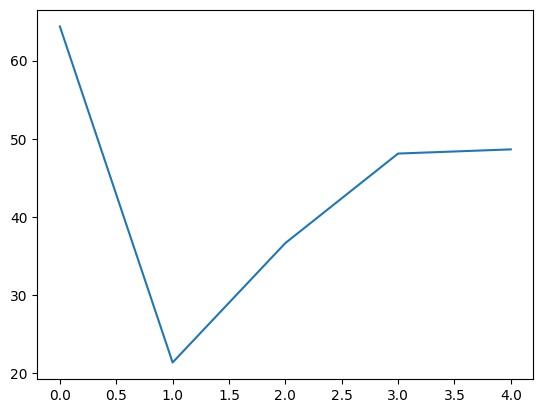

  0%|          | 600/41210000 [07:27<4987:23:06,  2.30it/s]

tensor(64.3207)


  0%|          | 700/41210000 [08:12<4939:02:30,  2.32it/s]

tensor(18.7386)


  0%|          | 800/41210000 [08:56<4947:19:22,  2.31it/s]

tensor(25.7301)


  0%|          | 900/41210000 [09:40<4925:10:13,  2.32it/s]

tensor(35.9275)


  0%|          | 1000/41210000 [10:25<5144:42:46,  2.22it/s]

tensor(40.3798)


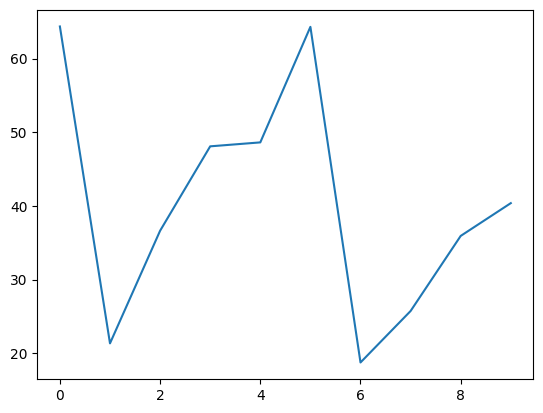

  0%|          | 1100/41210000 [11:09<4946:19:02,  2.31it/s]

tensor(45.7386)


  0%|          | 1200/41210000 [11:54<5118:45:32,  2.24it/s]

tensor(22.3082)


  0%|          | 1300/41210000 [12:39<5034:42:27,  2.27it/s]

tensor(59.4987)


  0%|          | 1400/41210000 [13:23<5033:58:01,  2.27it/s]

tensor(46.1971)


  0%|          | 1500/41210000 [14:08<5032:45:04,  2.27it/s]

tensor(53.2126)


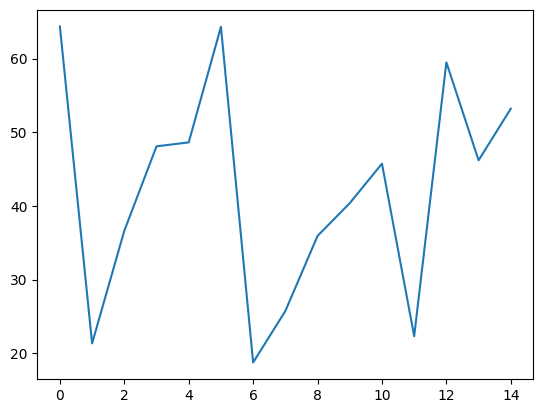

  0%|          | 1600/41210000 [14:53<4987:28:48,  2.30it/s]

tensor(54.2645)


  0%|          | 1700/41210000 [15:36<5052:40:22,  2.27it/s]

tensor(47.4620)


  0%|          | 1800/41210000 [16:21<4932:12:00,  2.32it/s]

tensor(48.2165)


  0%|          | 1900/41210000 [17:06<4936:08:08,  2.32it/s]

tensor(47.7262)


  0%|          | 2000/41210000 [17:50<5309:32:29,  2.16it/s]

tensor(30.2232)


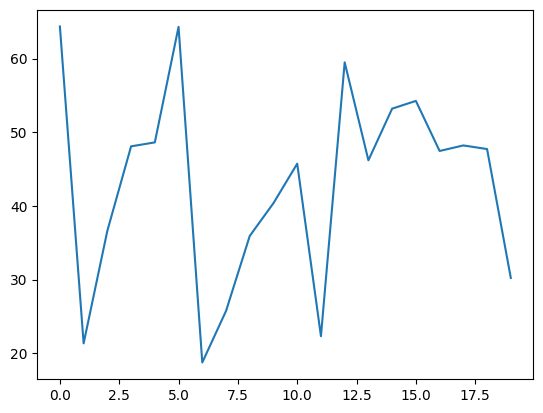

  0%|          | 2100/41210000 [18:34<4877:10:51,  2.35it/s]

tensor(67.2481)


  0%|          | 2200/41210000 [19:18<4989:10:05,  2.29it/s]

tensor(41.6147)


  0%|          | 2300/41210000 [20:02<4957:32:14,  2.31it/s]

tensor(44.9814)


  0%|          | 2400/41210000 [20:46<5499:55:38,  2.08it/s]

tensor(57.0115)


  0%|          | 2500/41210000 [21:30<4949:42:05,  2.31it/s]

tensor(48.8736)


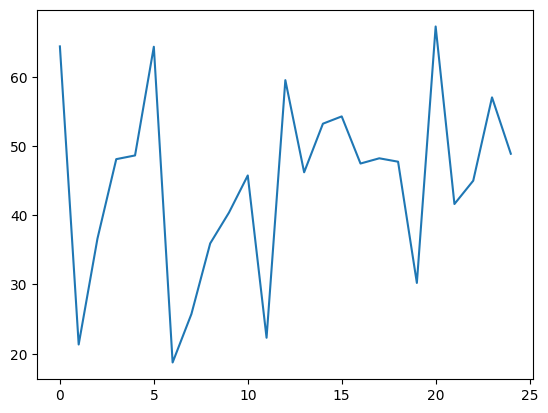

  0%|          | 2600/41210000 [22:14<4913:10:51,  2.33it/s]

tensor(31.6912)


  0%|          | 2700/41210000 [22:58<4949:23:23,  2.31it/s]

tensor(35.8814)


  0%|          | 2800/41210000 [23:42<5001:22:07,  2.29it/s]

tensor(52.4019)


  0%|          | 2900/41210000 [24:26<4953:14:39,  2.31it/s]

tensor(38.6305)


  0%|          | 3000/41210000 [25:10<5004:03:57,  2.29it/s]

tensor(84.9345)


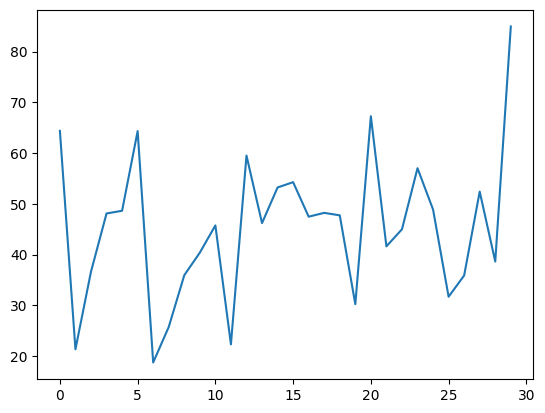

  0%|          | 3100/41210000 [25:54<5132:15:10,  2.23it/s]

tensor(27.9735)


  0%|          | 3200/41210000 [26:39<4877:38:29,  2.35it/s]

tensor(44.8203)


  0%|          | 3300/41210000 [27:22<4900:01:19,  2.34it/s]

tensor(23.2601)


  0%|          | 3400/41210000 [28:06<4895:04:39,  2.34it/s]

tensor(71.4491)


  0%|          | 3500/41210000 [28:50<5216:01:42,  2.19it/s]

tensor(48.7102)


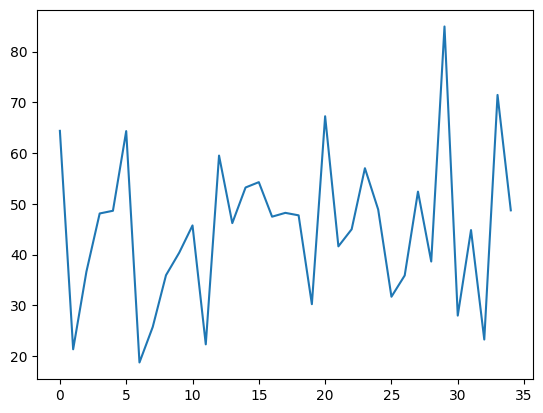

  0%|          | 3600/41210000 [29:34<4946:27:52,  2.31it/s]

tensor(36.6167)


  0%|          | 3700/41210000 [30:18<5165:50:36,  2.22it/s]

tensor(39.3272)


  0%|          | 3800/41210000 [31:02<4947:43:07,  2.31it/s]

tensor(58.1882)


  0%|          | 3900/41210000 [31:45<4913:27:46,  2.33it/s]

tensor(49.4017)


  0%|          | 4000/41210000 [32:29<4926:26:57,  2.32it/s]

tensor(67.8347)


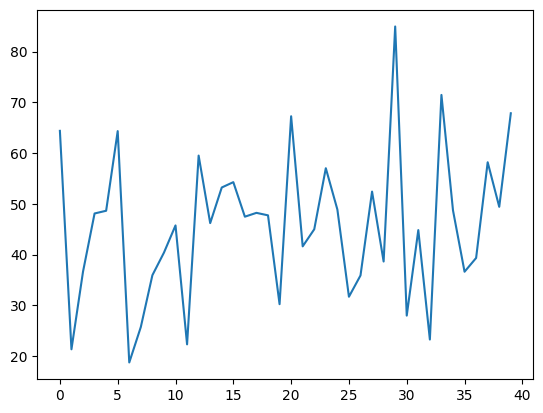

  0%|          | 4100/41210000 [33:13<4960:55:30,  2.31it/s]

tensor(39.6327)


  0%|          | 4200/41210000 [33:58<5313:44:26,  2.15it/s]

tensor(42.5874)


  0%|          | 4300/41210000 [34:42<4888:33:24,  2.34it/s]

tensor(19.7778)


  0%|          | 4400/41210000 [35:26<4949:20:34,  2.31it/s]

tensor(37.6896)


  0%|          | 4500/41210000 [36:10<5182:32:00,  2.21it/s]

tensor(34.8667)


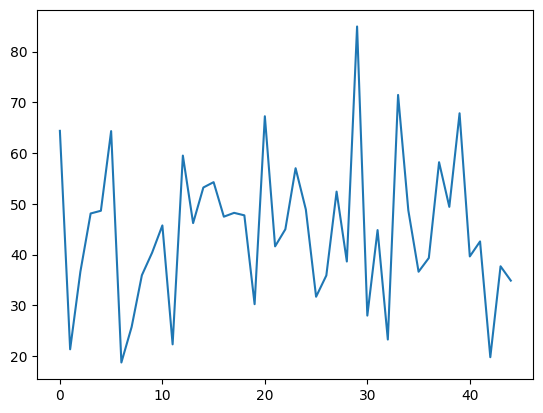

  0%|          | 4600/41210000 [36:55<5218:53:14,  2.19it/s]

tensor(44.4713)


  0%|          | 4700/41210000 [37:40<4903:40:28,  2.33it/s]

tensor(25.9915)


  0%|          | 4800/41210000 [38:24<5039:35:48,  2.27it/s]

tensor(26.4523)


  0%|          | 4900/41210000 [39:09<5129:00:04,  2.23it/s]

tensor(22.3366)


  0%|          | 5000/41210000 [39:52<4887:49:13,  2.34it/s]

tensor(38.1648)


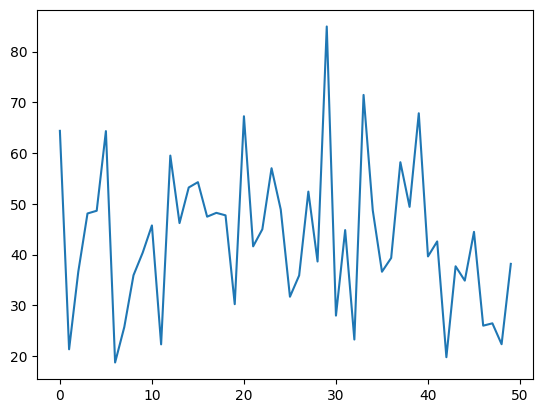

  0%|          | 5100/41210000 [40:36<4879:56:04,  2.35it/s]

tensor(47.7436)


  0%|          | 5200/41210000 [41:21<5118:10:42,  2.24it/s]

tensor(26.3278)


  0%|          | 5300/41210000 [42:05<4934:46:37,  2.32it/s]

tensor(52.6758)


  0%|          | 5400/41210000 [42:49<5198:18:58,  2.20it/s]

tensor(25.7275)


  0%|          | 5500/41210000 [43:34<5043:31:07,  2.27it/s]

tensor(35.5073)


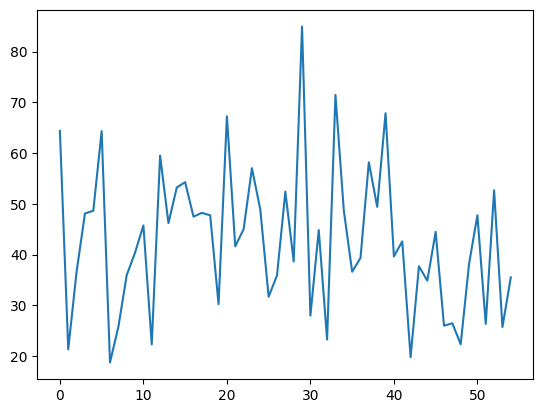

  0%|          | 5600/41210000 [44:18<5132:28:57,  2.23it/s]

tensor(40.0935)


  0%|          | 5700/41210000 [45:02<5036:42:09,  2.27it/s]

tensor(48.4656)


  0%|          | 5800/41210000 [45:47<5357:20:39,  2.14it/s]

tensor(50.9038)


  0%|          | 5900/41210000 [46:31<4956:09:36,  2.31it/s]

tensor(40.0580)


  0%|          | 6000/41210000 [47:15<5069:34:33,  2.26it/s]

tensor(17.5393)


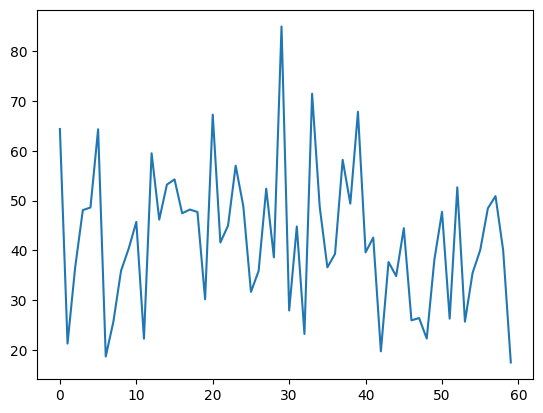

  0%|          | 6100/41210000 [47:59<4960:36:06,  2.31it/s]

tensor(35.7647)


  0%|          | 6200/41210000 [48:44<4884:19:50,  2.34it/s]

tensor(25.3992)


  0%|          | 6300/41210000 [49:29<5135:31:36,  2.23it/s]

tensor(37.8597)


  0%|          | 6400/41210000 [50:14<5106:16:01,  2.24it/s]

tensor(35.5863)


  0%|          | 6500/41210000 [50:59<5084:32:35,  2.25it/s]

tensor(55.9577)


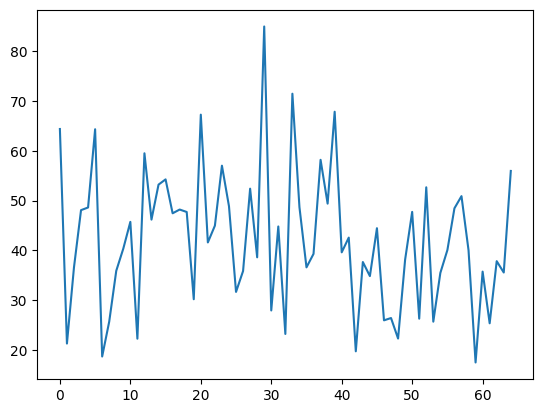

  0%|          | 6600/41210000 [51:43<5067:21:23,  2.26it/s]

tensor(74.5592)


  0%|          | 6700/41210000 [52:28<4986:00:23,  2.30it/s]

tensor(42.8403)


  0%|          | 6800/41210000 [53:13<5229:17:17,  2.19it/s]

tensor(21.8206)


  0%|          | 6900/41210000 [53:56<4933:08:02,  2.32it/s]

tensor(43.4886)


  0%|          | 7000/41210000 [54:41<5034:27:50,  2.27it/s]

tensor(48.6097)


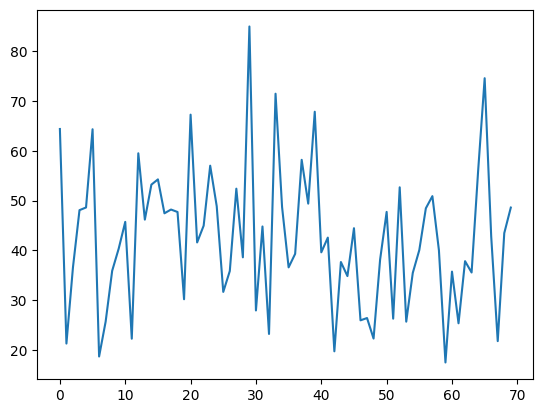

  0%|          | 7100/41210000 [55:25<5085:02:59,  2.25it/s]

tensor(44.3951)


  0%|          | 7200/41210000 [56:10<4980:48:56,  2.30it/s]

tensor(35.5931)


  0%|          | 7300/41210000 [56:54<5065:36:04,  2.26it/s]

tensor(22.8180)


  0%|          | 7400/41210000 [57:38<4903:38:12,  2.33it/s]

tensor(41.2185)


  0%|          | 7500/41210000 [58:23<4951:03:57,  2.31it/s]

tensor(53.1562)


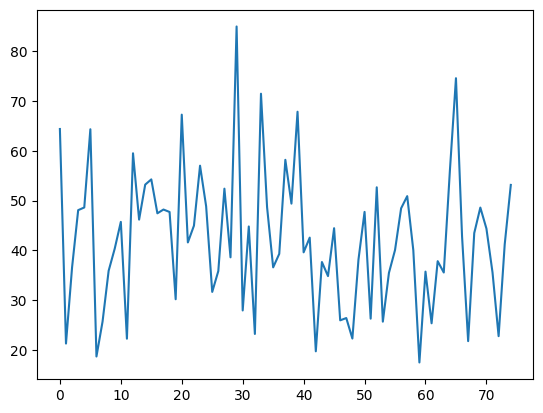

  0%|          | 7600/41210000 [59:08<4967:06:15,  2.30it/s]

tensor(43.8231)


  0%|          | 7700/41210000 [59:53<4932:46:11,  2.32it/s]

tensor(36.0010)


  0%|          | 7800/41210000 [1:00:37<5044:06:23,  2.27it/s]

tensor(32.4436)


  0%|          | 7900/41210000 [1:01:22<5694:48:49,  2.01it/s]

tensor(42.2403)


  0%|          | 8000/41210000 [1:02:07<5087:25:10,  2.25it/s]

tensor(59.6874)


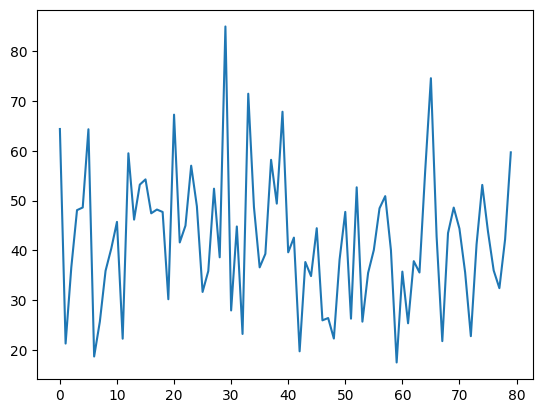

  0%|          | 8100/41210000 [1:02:51<5027:26:38,  2.28it/s]

tensor(39.3001)


  0%|          | 8200/41210000 [1:03:35<5188:45:10,  2.21it/s]

tensor(28.4101)


  0%|          | 8300/41210000 [1:04:20<5013:36:49,  2.28it/s]

tensor(47.0863)


  0%|          | 8400/41210000 [1:05:04<4996:49:21,  2.29it/s]

tensor(49.4211)


  0%|          | 8500/41210000 [1:05:48<5186:23:19,  2.21it/s]

tensor(37.2888)


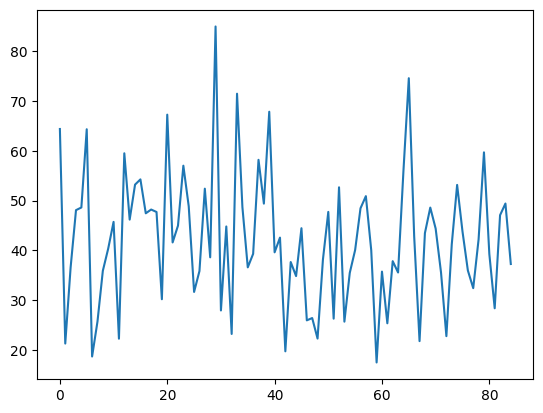

  0%|          | 8600/41210000 [1:06:32<4985:29:29,  2.30it/s]

tensor(18.6199)


  0%|          | 8700/41210000 [1:07:17<5566:52:43,  2.06it/s]

tensor(56.0332)


  0%|          | 8800/41210000 [1:08:01<4943:24:25,  2.32it/s]

tensor(58.6062)


  0%|          | 8900/41210000 [1:08:45<4919:11:08,  2.33it/s]

tensor(23.2592)


  0%|          | 9000/41210000 [1:09:29<4918:02:47,  2.33it/s]

tensor(37.1573)


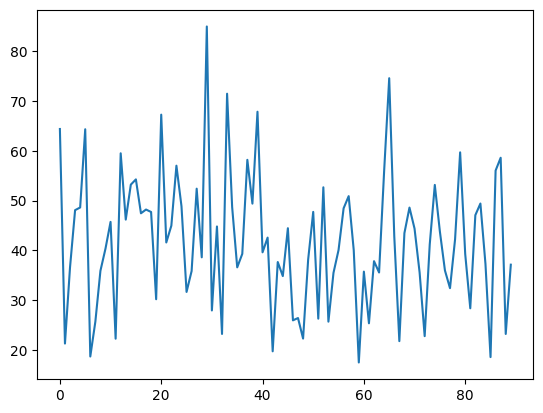

  0%|          | 9100/41210000 [1:10:13<5542:23:26,  2.06it/s]

tensor(49.7010)


  0%|          | 9195/41210000 [1:10:55<5032:06:20,  2.27it/s]

IndexError: Caught IndexError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/workspace/audiogen-finetune/audiodataset_seperation.py", line 56, in __getitem__
    data = self.df.iloc[synthesized_index] # self.audio_files_list[idx]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1192, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1753, in _getitem_axis
    self._validate_integer(key, axis)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexing.py", line 1686, in _validate_integer
    raise IndexError("single positional indexer is out-of-bounds")
IndexError: single positional indexer is out-of-bounds


In [12]:
losses = []

for epoch in range(starting_epoch, 3):
    accelerator.print(f"-------------------EPOCH{epoch}-------------------------" )
    total_loss, total_val_loss = 0, 0
    model.train()
    
    for batch_idx, (synthesized_wav, prompts, ground_truth, lengths) in enumerate(audio_dataloader):
        # Consider batch
        with accelerator.accumulate(model):
            # print(1)
            with torch.no_grad():
                unwrapped_vae = accelerator.unwrap_model(compression_model)
                synthesized_audio_tokens = process_audio_tokenizer(synthesized_wav, unwrapped_vae)
                synthesized_audio_tokens, synthesized_padding_mask = post_process_audio_tokenizer(synthesized_audio_tokens, lengths, unwrapped_vae, lm, cfg)
                # print(2)
                
                audio_tokens = process_audio_tokenizer(ground_truth, unwrapped_vae)
                audio_tokens, padding_mask = post_process_audio_tokenizer(audio_tokens, lengths, unwrapped_vae, lm, cfg)
                # print(3)
                
                attributes = [
                    ConditioningAttributes(text={'description': str(description)})
                    for description in prompts
                ]
            # print(3)

            mask_token_seperation = torch.tensor([[[lm.special_token_id],[lm.special_token_id],[lm.special_token_id],[lm.special_token_id]]]).to(accelerator.device)
            mask_padding_token_seperation = torch.ones(mask_token_seperation.shape, dtype=int).to(accelerator.device)
            
            made_up_tokens = torch.concatenate((synthesized_audio_tokens, mask_token_seperation, audio_tokens), dim=2)
            made_padding_tokens = torch.concatenate((synthesized_padding_mask, mask_padding_token_seperation, padding_mask), dim=2)
            # print(4)
            
            loss, model_output = model(made_up_tokens, made_padding_tokens, attributes)
            # print(5)
            ppl =  torch.exp(loss)
            total_loss += loss.detach().cpu().float()
            accelerator.backward(loss)     
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            torch.cuda.empty_cache()
            
            if accelerator.sync_gradients:
                progress_bar.update(1)
                completed_steps += 1
            
            if batch_idx % 100==99:
                print(total_loss)
                losses.append(total_loss)
                total_loss = 0
            if batch_idx % 500==499:
                plt.plot(losses)
                plt.show()

In [ ]:

# import pandas as pd

# dff = pd.read_csv(eval_data_path)
# import random

# randoms = []
# for i in range(len(dff)):
#     random_integer = random.randint(0, len(dff))
#     while random_integer == i:
#         random_integer = random.randint(0, len(dff))
#     randoms.append(random_integer)

# dff['synthesized_index'] = randoms

# dff[:10]

# dff.to_csv(eval_data_path, index=False)  # 'your_file_modified.csv' will be the new file with the additional column